In [55]:
import string
from requests.exceptions import Timeout
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from datetime import datetime
from scipy.stats import linregress
from api_keys import g_key
import gmaps


In [56]:
##### read data
fatality = pd.read_csv('data/ACCIDENT.csv')
injury_property_damage = pd.read_csv('data/injury_and_property_damage_only.csv')
vehicle_miles = pd.read_csv('data/vehicle_miles.csv')
injury_property_damage.head(10)

,caseyear,injury_only,property_damage_only
0,2010,1542104,3847045
1,2011,1529968,3777994
2,2012,1634180,3949858
3,2013,1591016,4065673
4,2014,1647726,4386502
5,2015,1715394,4548203
6,2016,2116308,4670073
7,2017,1888525,4529513
8,2018,1893704,4807058
9,2019,1916344,4806253


In [57]:
fatality.head()

,caseyear,st_case,statename,latitude,longitud,fatals,lgt_condname,drunk_dr,fatals.1,day_weekname,day_week
0,2010,10001,Alabama,32.641064,-85.354692,1,Dark - Lighted,1,1,Friday,6
1,2010,10002,Alabama,31.430447,-86.956694,1,Dark - Lighted,0,1,Monday,2
2,2010,10003,Alabama,30.691631,-88.085778,1,Daylight,0,1,Thursday,5
3,2010,10004,Alabama,33.868700,-86.291164,1,Dark - Lighted,0,1,Thursday,5
4,2010,10005,Alabama,33.309742,-86.787222,1,Dawn,0,1,Monday,2


In [58]:
vehicle_miles.head(15)

,caseyear,vehicle_miles_milions,mode
0,2010,5975.78,Air
1,2011,6004.58,Air
2,2012,5956.17,Air
3,2013,5964.98,Air
4,2014,5947.35,Air
5,2015,6045.82,Air
6,2016,6227.35,Air
7,2017,6337.80,Air
8,2018,6609.01,Air
9,2019,6815.00,Air


In [59]:
# number of fatal_only crashes
fatal_case_by_year = fatality.groupby(['caseyear']).count()['fatals'].reset_index()
fatal_case_by_year.rename(columns={'fatals':'fatals_case_only'},inplace=True)
# number of death
death_by_year = fatality.groupby('caseyear').sum()['fatals'].reset_index()
# create summary table: merge data and calculate
summary_crash_case = fatal_case_by_year.merge(injury_property_damage,on='caseyear')
summary_crash_case = summary_crash_case.merge(death_by_year,on='caseyear')
summary_crash_case['total_crash'] = summary_crash_case.fatals_case_only + summary_crash_case.injury_only + summary_crash_case.property_damage_only
summary_crash_case = summary_crash_case.merge(vehicle_miles.loc[vehicle_miles['mode'] == 'Car',['caseyear','vehicle_miles_milions']],on='caseyear')
summary_crash_case['fatality_per_thousand_crash'] = summary_crash_case.fatals / summary_crash_case.total_crash * 1000
summary_crash_case['fatality_per_vmt'] = summary_crash_case.fatals / summary_crash_case.vehicle_miles_milions 
summary_crash_case.to_csv('summary_data/car.csv',index=False)
summary_crash_case.tail()

,caseyear,fatals_case_only,injury_only,property_damage_only,fatals,total_crash,vehicle_miles_milions,fatality_per_thousand_crash,fatality_per_vmt
6,2016,35017,2116308,4670073,38085,6821398,3174407.96,5.583166,0.011998
7,2017,34841,1888525,4529513,37763,6452879,3212347.31,5.852117,0.011756
8,2018,34214,1893704,4807058,37143,6734976,3240326.54,5.514942,0.011463
9,2019,33762,1916344,4806253,36644,6756359,3261771.66,5.423631,0.011234
10,2020,35995,1593390,3621681,39066,5251066,2903621.53,7.439632,0.013454


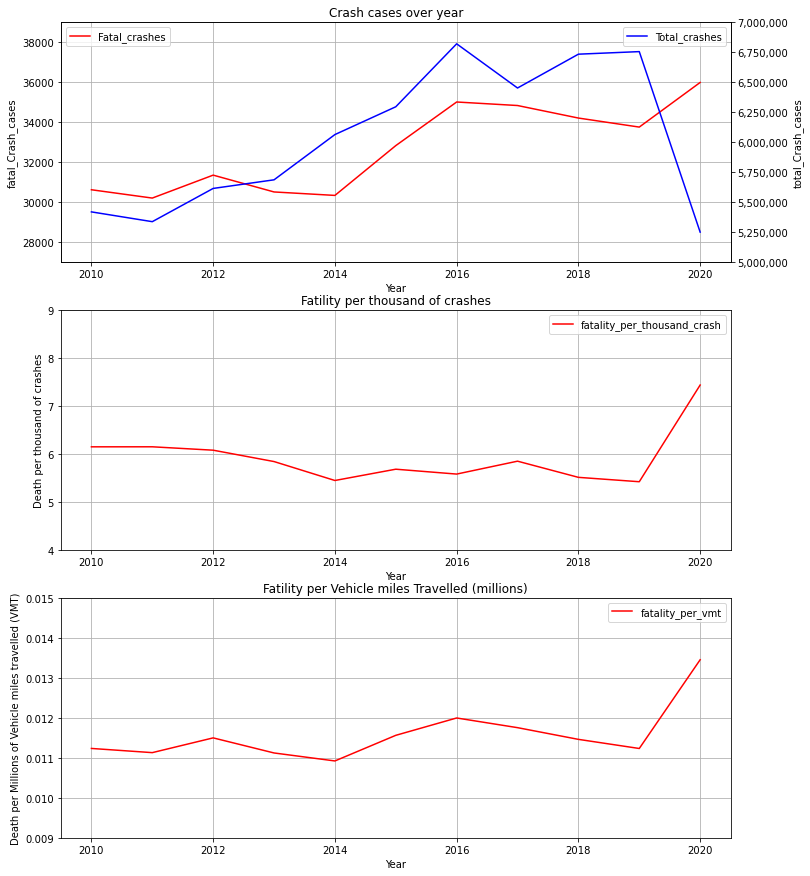

In [60]:
# plot total fatal crashes per year
fig, (p1,p2,p3) = plt.subplots(3,figsize=(12, 15))
summary_crash_case.plot.line(x='caseyear',y='fatals_case_only',ax=p1,color='r',title='Crash cases over year')
summary_crash_case.plot.line(x='caseyear',y='total_crash',secondary_y=True,ax=p1,color='b')
#p1.title('Crash cases over year')
p1.legend(['Fatal_crashes'],loc='upper left')
p1.right_ax.legend(['Total_crashes'])
p1.set_ylim(27000,39000)
p1.right_ax.set_ylim(5000000,7000000)
p1.set_xlabel("Year")
p1.set_ylabel('fatal_Crash_cases')
p1.right_ax.set_ylabel('total_Crash_cases')
p1.right_ax.ticklabel_format(style='plain')
p1.right_ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
p1.grid()

#plot total death per thousand of crashes
summary_crash_case.plot.line(x='caseyear',y='fatality_per_thousand_crash',ax=p2,title='Fatility per thousand of crashes',color='r')
p2.set_ylim(4,9)
p2.set_xlabel("Year")
p2.set_ylabel('Death per thousand of crashes')
p2.grid()
#plot total death per Vehicle miles travelled
summary_crash_case.plot.line(x='caseyear',y='fatality_per_vmt',ax=p3,title='Fatility per Vehicle miles Travelled (millions)',color='r')
p3.set_ylim(0.009,0.015)
p3.set_xlabel("Year")
p3.set_ylabel('Death per Millions of Vehicle miles travelled (VMT)')
p3.grid()

p1.figure.savefig('Output/Crash cases over year.png',bbox_inches='tight')


In [61]:
# create death per state dataframe
death_by_state = fatality.groupby(['caseyear','statename']).sum()['fatals'].reset_index()
#### top 5 states with highest death
summary_crash_top_state = death_by_state.sort_values('fatals',ascending=False).groupby('caseyear').head(5)
summary_crash_top_state = summary_crash_top_state.sort_values(['caseyear','fatals'],ascending=[True,False])
summary_crash_top_state = summary_crash_top_state.pivot(index='caseyear', columns='statename', values='fatals')
summary_crash_top_state=summary_crash_top_state [['Texas','California','Florida','Pennsylvania','North Carolina','Georgia']]
summary_crash_top_state

statename,Texas,California,Florida,Pennsylvania,North Carolina,Georgia
caseyear,,,,,,
2010,3023.0,2720.0,2444.0,1324.0,1320.0,NaN
2011,3054.0,2816.0,2400.0,1286.0,1230.0,NaN
2012,3408.0,2966.0,2431.0,1310.0,1299.0,NaN
2013,3389.0,3107.0,2403.0,1210.0,1290.0,NaN
2014,3536.0,3102.0,2494.0,1195.0,1284.0,NaN
2015,3582.0,3387.0,2938.0,NaN,1379.0,1432.0
2016,3797.0,3837.0,3176.0,NaN,1450.0,1556.0
2017,3732.0,3884.0,3116.0,NaN,1412.0,1540.0
2018,3648.0,3798.0,3135.0,NaN,1436.0,1505.0


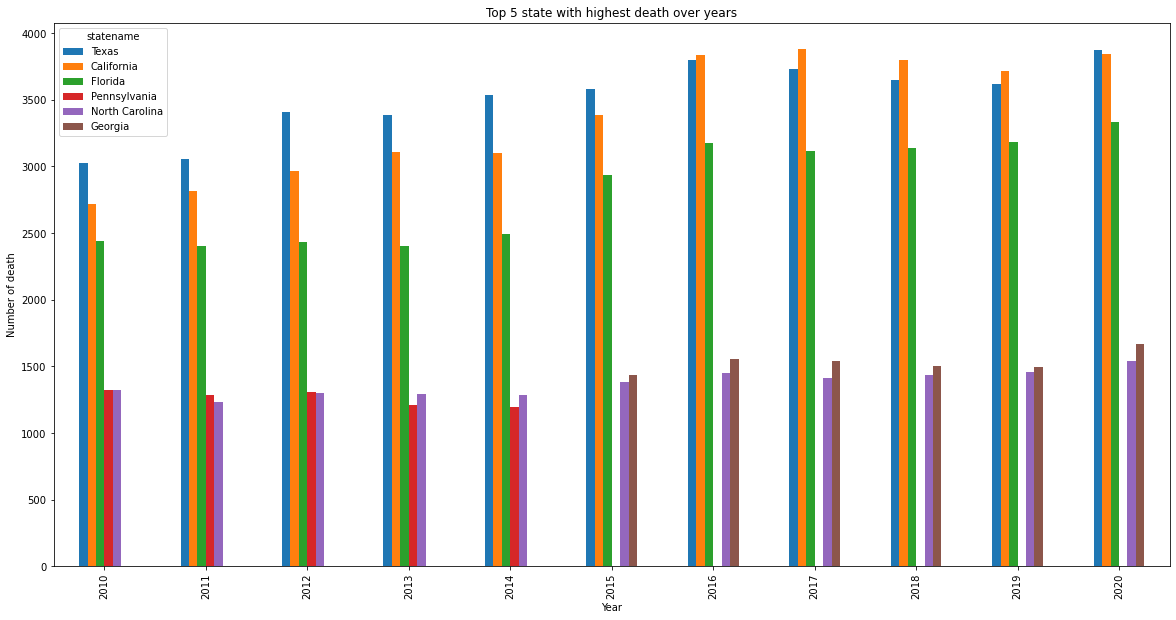

In [62]:
#plot top 5 states with highest death per year
fig, p = plt.subplots(figsize = (20,10))
summary_crash_top_state.plot(kind='bar', ax=p,title ='Top 5 state with highest death over years')
p.set_xlabel('Year')
p.set_ylabel('Number of death')
p.figure.savefig('Output/Top 5 state with highest death over years.png',bbox_inches='tight')

In [63]:
#create death location dataframe
death_location = fatality[['caseyear','statename','latitude','longitud','fatals']]
#removed unknown location
death_location = death_location.loc[(death_location.latitude>=-90)&(death_location.latitude<=90)&(death_location.longitud>=-180)&(death_location.longitud<=180),:]
death_location.head()

,caseyear,statename,latitude,longitud,fatals
0,2010,Alabama,32.641064,-85.354692,1
1,2010,Alabama,31.430447,-86.956694,1
2,2010,Alabama,30.691631,-88.085778,1
3,2010,Alabama,33.868700,-86.291164,1
4,2010,Alabama,33.309742,-86.787222,1


In [64]:
#create head map of fatal crash locations
gmaps.configure(api_key=g_key)
crash_loc_df= death_location[['latitude', 'longitud']]
weight = death_location['fatals']
fig = gmaps.figure(zoom_level=4,
                   center=(38.58,-96.46),
                   layout={'width': '1000px',
                    'height': '600px',
                    'padding': '3px',
                    'border': '1px solid black'})
heatmap_layer = gmaps.heatmap_layer(crash_loc_df,weights=weight,max_intensity=5000,point_radius=28,dissipating=True)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', padding='3px', width='1000px'))

In [65]:
#analyse fatality per causes
cause_df = fatality[['caseyear','statename','lgt_condname','drunk_dr','fatals','day_weekname','day_week','st_case']]
cause_df.head()


,caseyear,statename,lgt_condname,drunk_dr,fatals,day_weekname,day_week,st_case
0,2010,Alabama,Dark - Lighted,1,1,Friday,6,10001
1,2010,Alabama,Dark - Lighted,0,1,Monday,2,10002
2,2010,Alabama,Daylight,0,1,Thursday,5,10003
3,2010,Alabama,Dark - Lighted,0,1,Thursday,5,10004
4,2010,Alabama,Dawn,0,1,Monday,2,10005


c:\Users\datqu\anaconda3\envs\bootcamp\lib\site-packages\pandas\core\indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
c:\Users\datqu\anaconda3\envs\bootcamp\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


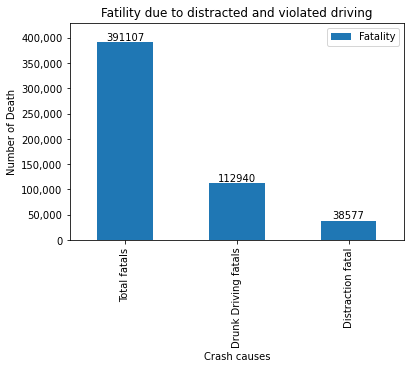

In [66]:
#fatality vs drunk driver and distraction 
cause_df.loc[cause_df['drunk_dr']>=1,'drunk_driver']='YES'
cause_df.loc[cause_df['drunk_dr']==0,'drunk_driver']='NO'
drunk_drive = cause_df.groupby('drunk_driver').sum()['fatals'].reset_index()
drunk_drive.set_index('drunk_driver',inplace=True)
#get distraction data
distract = pd.read_csv('data/DISTRACT.csv')
#categorize distraction and violation type
bin = [-1,0,0.2,0.5,0.7,1000]
labels = ['No Distraction', 'Unknow if Distracted','Not Reported','No Driver Present' , 'Distracted']
distract['distraction_category']=pd.cut(distract['distract_code'],bins=bin,labels=labels)
#merge to get fatals data
distraction = distract.merge(cause_df,on=['caseyear','st_case'],how='left')
#calculate fatals data for each category
Total_fatals = summary_crash_case.fatals.sum()
distracted_fatals = distraction.loc[distraction['distraction_category']=='Distracted','fatals'].sum()
drunk_drive_fatals = cause_df.loc[cause_df['drunk_driver']=='YES','fatals'].sum()

#create dataframe for plotting
drunk_distraction = pd.DataFrame({'category':['Total fatals','Drunk Driving fatals','Distraction fatal'],
                                      'Death':[Total_fatals,drunk_drive_fatals,distracted_fatals]})
drunk_distraction.set_index('category',inplace=True)
p=drunk_distraction.plot.bar(title='Fatility due to distracted and violated driving')
p.set_xlabel ('Crash causes')
p.set_ylabel ('Number of Death')
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
p.legend(['Fatality'])
p.bar_label(p.containers[0])
p.set_ylim(0,430000)

p.figure.savefig('Output/drunk_distraction_fatals.png',bbox_inches='tight')

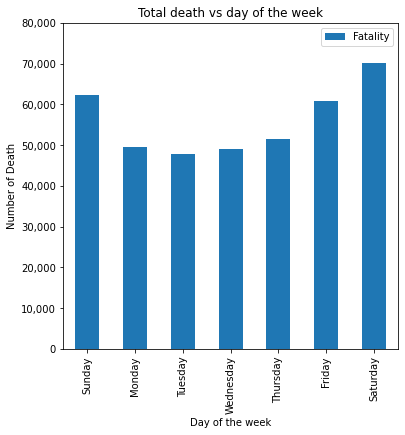

In [74]:
#fatility vs day in week
#week date list
day_map = cause_df[['day_week','day_weekname']].drop_duplicates()
#aggregate data per weekdate
day_of_week_df = cause_df.sort_values('day_week',ascending=True)
day_of_week_df=day_of_week_df.groupby('day_weekname').sum()['fatals'].reset_index()
day_of_week_df=day_of_week_df.merge(day_map,on='day_weekname').sort_values('day_week',ascending=True)
del day_of_week_df['day_week']
day_of_week_df.set_index('day_weekname',inplace=True)
p = day_of_week_df.plot.bar(figsize =(6,6),title='Total death vs day of the week')
p.set_xlabel ('Day of the week')
p.set_ylabel ('Number of Death')
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
p.legend(['Fatality'])
p.set_ylim(0,80000)
p.figure.savefig('Output/days_of_week_fatals.png',bbox_inches='tight')

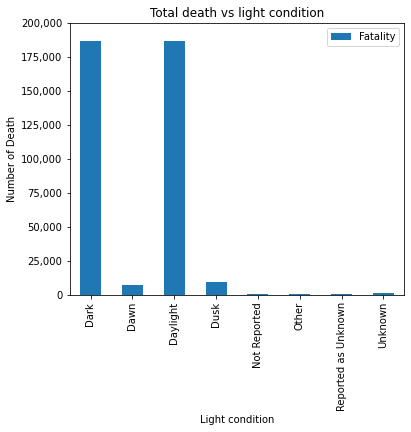

In [75]:
#fatility vs light
#consolidate dark data
light_condition_crash_df = cause_df.replace ({'Dark - Lighted':'Dark',
                                              'Dark - Not Lighted':'Dark',
                                              'Dark - Unknown Lighting':'Dark'})
light_condition_crash_df = light_condition_crash_df.groupby('lgt_condname').sum()['fatals'].reset_index()
light_condition_crash_df.set_index('lgt_condname',inplace=True)
p = light_condition_crash_df.plot.bar(figsize =(6,5),title='Total death vs light condition')
p.set_xlabel ('Light condition')
p.set_ylabel ('Number of Death')
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
p.legend(['Fatality'])
p.set_ylim(0,200000)
p.figure.savefig('Output/light_condition_fatals.png',bbox_inches='tight')


(0.0, 430000.0)

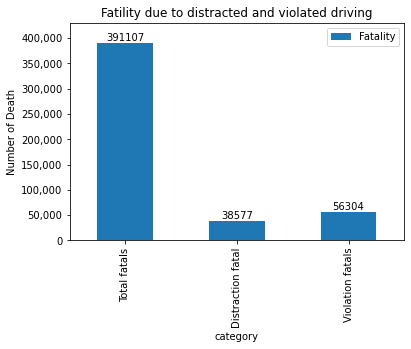

In [69]:
#fatility vs violation and distraction
violation = pd.read_csv('data/VIOLATION.csv')
distract = pd.read_csv('data/DISTRACT.csv')
#categorize distraction and violation type
bin = [-1,0,0.2,0.5,0.7,1000]
labels1 = ['No Violation', 'Unknow if Violated', 'Not Reported', 'No Driver Present' , 'Violated']
labels2 = ['No Distraction', 'Unknow if Distracted','Not Reported','No Driver Present' , 'Distracted']
violation['violation_category']=pd.cut(violation['violation_code'],bins=bin,labels=labels1)
distract['distraction_category']=pd.cut(distract['distract_code'],bins=bin,labels=labels2)
#merge to get fatals data
violation_distraction = violation.merge(distract,on=['caseyear','st_case'],how='left')
violation_distraction = violation_distraction.merge(cause_df,on=['caseyear','st_case'],how='left')
#calculate fatals data for each category
Total_fatals = summary_crash_case.fatals.sum()
violated_fatals = violation_distraction.loc[violation_distraction['violation_category']=='Violated','fatals'].sum()
distracted_fatals = violation_distraction.loc[violation_distraction['distraction_category']=='Distracted','fatals'].sum()
#create dataframe for plotting
violation_distraction = pd.DataFrame({'category':['Total fatals','Distraction fatal','Violation fatals'],
                                      'Death':[Total_fatals,distracted_fatals,violated_fatals]})
violation_distraction.set_index('category',inplace=True)
p=violation_distraction.plot.bar(title='Fatility due to distracted and violated driving')
p.set_ylabel ('Number of Death')
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
p.legend(['Fatality'])
p.bar_label(p.containers[0])
p.set_ylim(0,430000)

In [70]:
#some statistic on the person
people = pd.read_csv('data/PERSON.csv')
people.head()

,caseyear,st_case,age,sexname,per_typ,per_typname,inj_sev,inj_sevname
0,2010,10001,51,Female,1,Driver,4,Fatal Injury (K)
1,2010,10001,999,Male,2,Passenger,3,Incapacitating Injury (A)
2,2010,10002,44,Female,1,Driver,4,Fatal Injury (K)
3,2010,10003,27,Male,1,Driver,4,Fatal Injury (K)
4,2010,10003,45,Female,1,Driver,0,No Injury (O)


Median driver age involved in fatal crashes is 41.0


Text(0.5, 1.0, 'Age distribution of drivers involved in fatal crashes')

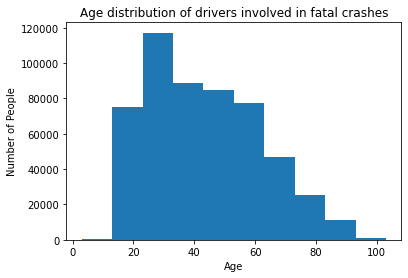

In [71]:
#driver age distribution
driver = people.loc[people.per_typname=='Driver',['age','sexname']]
Age_distribution = driver.loc[(driver['age']!=999)&(driver['age']!=998),:]
print(f'Median driver age involved in fatal crashes is {driver.age.median()}')
plt.hist(Age_distribution['age'])
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.title('Age distribution of drivers involved in fatal crashes')

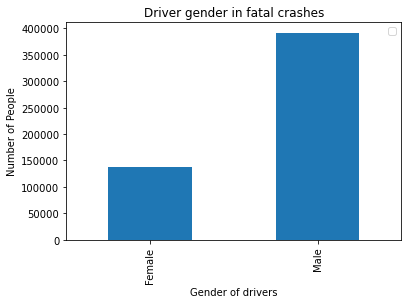

In [79]:
#driver sex distribution
sex = driver.loc[(driver.sexname=='Female')|(driver.sexname=='Male'),:]
p = sex.groupby('sexname').count().rename(columns={'age':'count'}).plot.bar()
plt.xlabel('Gender of drivers')
plt.ylabel('Number of People')
plt.legend('')
plt.title('Driver gender in fatal crashes')
p.figure.savefig('Output/drivers_gender.png',bbox_inches='tight')

Text(0, 0.5, 'Number of People')

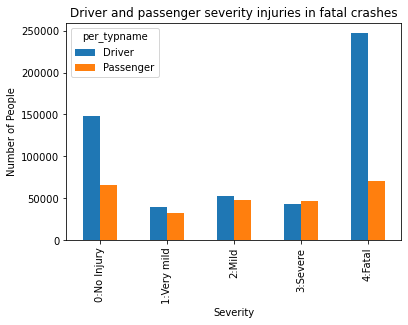

In [73]:
#driver vs passenger injury
passenger_vs_driver = people.loc[people.per_typname!='Unknown',:]
df=passenger_vs_driver[['per_typname','inj_sev','age']].groupby(['inj_sev','per_typname']).count().reset_index().rename(columns={'age':'count'})
df = df.loc[df.inj_sev<=4,:]
df['inj_sev'] = df['inj_sev'].replace({0:'0:No Injury',
                            1:'1:Very mild',
                            2:'2:Mild',
                            3:'3:Severe',
                            4:'4:Fatal'})
df_pivot=df.pivot(index='inj_sev',columns='per_typname',values='count')
df_pivot.plot.bar()
plt.title('Driver and passenger severity injuries in fatal crashes')
plt.xlabel('Severity')
plt.ylabel('Number of People')


In [82]:
people

,caseyear,st_case,age,sexname,per_typ,per_typname,inj_sev,inj_sevname
0,2010,10001,51,Female,1,Driver,4,Fatal Injury (K)
1,2010,10001,999,Male,2,Passenger,3,Incapacitating Injury (A)
2,2010,10002,44,Female,1,Driver,4,Fatal Injury (K)
3,2010,10003,27,Male,1,Driver,4,Fatal Injury (K)
4,2010,10003,45,Female,1,Driver,0,No Injury (O)
...,...,...,...,...,...,...,...,...
806134,2020,560114,18,Female,1,Driver,1,Possible Injury (C)
806135,2020,560114,17,Female,2,Passenger,1,Possible Injury (C)
806136,2020,560114,24,Male,1,Driver,0,No Apparent Injury (O)
806137,2020,560115,76,Male,1,Driver,4,Fatal Injury (K)
